In [4]:
#!pip install pyathena

In [2]:
from pyathena import connect
import pandas as pd


In [3]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name = 'viamericas'
database_name2= 'analytics'
table1_name = 'forex_feed_market'
table2_name = 'daily_sales_not_cancellations'

In [4]:
#Connection
conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')
#df1 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table1_name};', conn)
df2 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name2}.{table2_name};', conn)

/tmp/ipykernel_1912/1299455614.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name2}.{table2_name};', conn)


In [5]:
df2.shape

(103726, 4)

In [6]:
df2.head()

,payer,country,date,amount
0,BANCO GANADERO (BOLIVIA),BOLIVIA,2023-03-22,11165.00
1,BANPAIS (RED CHAPINA),HONDURAS,2022-03-31,24800.00
2,BANCO DEL AUSTRO,ECUADOR,2021-02-23,66735.51
3,TELEDOLAR,COSTA RICA,2022-06-18,82151.00
4,BANORTE (UT),MEXICO,2021-08-16,432104.72


In [7]:
##TO SPEED UP THE LOADING, WE ALREADY WORK WITH THE EXTRACTED CSV##

In [81]:
df_rates=pd.read_csv('Rates_csv/rates_2021_2023.csv')

In [82]:
df_rates.symbol.unique()

array(['USDBRL', 'USDINR', 'USDGTQ', 'USDMXN', 'USDPHP'], dtype=object)

In [19]:
df2['date'] = pd.to_datetime(df2['date'])

In [20]:
##WE MERGE THE DATASETS TO HAVE TRADED AMOUNTS AND EXCHANGE RATES PER DAY##

In [21]:
rates = rates.rename(columns={'feed_date': 'date'})
rates['date'] = pd.to_datetime(rates['date'])

rates.head()

,symbol,date,feed_price
0,USDMXN,2021-01-01,19.8822
1,USDMXN,2021-01-02,19.8822
2,USDMXN,2021-01-04,19.9046
3,USDMXN,2021-01-05,19.9196
4,USDMXN,2021-01-06,19.6648


In [22]:
###WE OBTAIN THE LAGS OF UP TO 7 DAYS FOR THE EXCHANGE RATE 

In [23]:
for i in range(1, 8):
        nombre_columna = f'feed_price_retardo_{i}'
        rates[nombre_columna] = rates['feed_price'].shift(i)

In [24]:
rates.head(3)

,symbol,date,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
0,USDMXN,2021-01-01,19.8822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USDMXN,2021-01-02,19.8822,19.8822,NaN,NaN,NaN,NaN,NaN,NaN
2,USDMXN,2021-01-04,19.9046,19.8822,19.8822,NaN,NaN,NaN,NaN,NaN


In [29]:
###WE MERGE THE RESULTING DATABASE WITH THE DATABASE OF RATES##

In [30]:
df_final=pd.merge(df_montos_mex, rates, on='date', how='left')

In [31]:
df_final.head(3)

,payer,country,date,amount,symbol,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
0,BANORTE (UT),MEXICO,2021-08-16,432104.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BBVA - BANCOMER (BTS),MEXICO,2021-03-09,441355.68,USDMXN,21.2154,21.2901,21.3151,21.1320,20.9352,20.6115,20.706,20.7831
2,BANCOPPEL (BTS),MEXICO,2021-02-21,2202623.18,USDMXN,20.5105,20.4272,20.4346,19.9557,19.9372,19.9374,19.988,20.0233


In [32]:
##AS PART OF A PILOT TEST WE WILL ONLY WORK WITH ONE PAYER, AND THEN WE WILL GENERALIZE THE ROUTINE##
## WE WILL NOW FIT A MODEL WITH LAGS OF THE EXCHANGE RATE (SARIMAX) TO SEE IF IT PERFORMS BETTER THAN THE SIMPLE ARIMA MODEL.
##WE START WITH ELEKTRA AND THE CASE WITHOUT EXOGENOUS VARIABLES ##
df_pilot=df_final.loc[df_final.payer=='ELEKTRA (MEXICO)']
df_pilot.shape

(1025, 13)

In [33]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
##TIME SERIES FORMAT
data = df_pilot
data.dtypes #day object
data['date'] = pd.DatetimeIndex(data['date'])
df_pilot.dtypes   # datetime64[ns]

data.index  #RangeIndex()
data = data.set_index('date')

/tmp/ipykernel_1912/2650643092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.DatetimeIndex(data['date'])


In [38]:
##WE ELIMINATE STRING VARIABLES AND OTHER VARIABLES##
data=data.loc[:,['amount']]

In [39]:
data = data.sort_values(by='date')

In [40]:
data.head(3)

,amount
date,
2020-12-31,2418346.71
2021-01-01,717241.42
2021-01-02,3360407.85


In [43]:
##STATIONARITY TESTS AUTOCORRELATION GRAPHS
##NON-STATIONARY SERIES##
##The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. 
##If the pvalue is above a critical size, then we cannot reject that there is a unit root.
##In this case (ELEKTRA MÉXICO) we check that the series is non-stationary (0.58>0.05)

In [46]:
##ARIMA PARAMETER SEARCH##

In [47]:
##SPLIT THE DATABASE INTO TRAIN AND TEST (WITH THE DATABASE SORTED TEMPORALLY)##

In [41]:
traindata = data[0:800] #data[0:800]
traindata.index

DatetimeIndex(['2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09',
               ...
               '2023-03-01', '2023-03-02', '2023-03-03', '2023-03-04',
               '2023-03-05', '2023-03-06', '2023-03-07', '2023-03-08',
               '2023-03-09', '2023-03-10'],
              dtype='datetime64[ns]', name='date', length=800, freq=None)

In [42]:
testdata = data[801:1025] #data[801:1025]
testdata.index

DatetimeIndex(['2023-03-12', '2023-03-13', '2023-03-14', '2023-03-15',
               '2023-03-16', '2023-03-17', '2023-03-18', '2023-03-19',
               '2023-03-20', '2023-03-21',
               ...
               '2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15',
               '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19',
               '2023-10-20', '2023-10-21'],
              dtype='datetime64[ns]', name='date', length=224, freq=None)

In [43]:
traindata.shape, testdata.shape

((800, 1), (224, 1))

In [51]:
##WE INSTALL A TIME SERIES LIBRARY THAT HELPS US TO SELECT THE BEST ARIMA MODEL AUTOMATICALLY##
#!pip install pmdarima

In [52]:
##WE APPLY THE AUTOARIMA MODULE THAT SELECTS THE BEST MODEL FROM AMONG SEVERAL CANDIDATES
## BASED ON THE AUTOCORRELATION GRAPH, WE OBSERVE THAT VALUES OF UP TO 14 LAGS CAN AFFECT TODAY'S AMOUNT. WHICH IMPLIES P AND Q MAX=14 (ALWAYS TAKE CARE OF MODEL PARSIMONY).

In [44]:
# Import the library, require install and restart, uncomment to use
from pmdarima import auto_arima 

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function  dataset 
# Adjusts the best arima model by looking for the one that minimizes the Akaike criterion (AIC)
stepwise_fit = auto_arima(traindata['amount'], start_p = 1, start_q = 1, 
                          max_p = 14, max_q = 14, m = 7 , 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
#p:The order of the auto-regressive (AR) model (i.e., the number of lag observations). A time series is considered AR when previous values in the time series are very predictive of later values.
#d:The degree of differencing.
#q:The order of the moving average (MA) model. This is essentially the size of the “window” function over your time series data. An MA process is a linear combination of past errors.

# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=23673.304, Time=0.44 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=24060.954, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=23774.062, Time=0.34 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=23714.935, Time=0.37 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=24061.270, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=23856.346, Time=0.22 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=23645.152, Time=0.53 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=23775.256, Time=0.46 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=23644.235, Time=1.70 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=23726.563, Time=1.03 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=23642.408, Time=2.45 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=23642.666, Time=1.70 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=23692.049, Time=2.49 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=23642.579, Time=1.90 sec
 ARIMA(2,0,1)(2,1,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  800
Model:             SARIMAX(4, 0, 0)x(2, 1, [1, 2], 7)   Log Likelihood              -11810.856
Date:                                Wed, 03 Jan 2024   AIC                          23641.711
Time:                                        15:14:31   BIC                          23688.469
Sample:                                    12-31-2020   HQIC                         23659.681
                                         - 03-10-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    2.33e+04   9579.037      2.433      0.015    4529.511    4.21e+04
ar.L1          0.5313      0.021     24.824      0.000       0.489       0.573
ar.L2         -0.0319      0.038     -0.835      0.404      -0.107       0.043
ar.L3          0.0272      0.067      0.405      0.685      -0.104       0.159
ar.L4          0.0661      0.066      1.000      0.317      -0.063       0.196
ar.S.L7       -0.6055      0.199     -3.050      0.002      -0.995      -0.216
ar.S.L14       0.2330      0.096      2.434      0.015       0.045       0.421
ma.S.L7        0.0077      0.193      0.040      0.968      -0.370       0.386
ma.S.L14      -0.8119      0.185     -4.396      0.000      -1.174      -0.450
sigma2      6.647e+11      0.001   6.02e+14      0.000    6.65e+11    6.65e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             19315.70
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.05   Skew:                            -2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.17e+29. Standard errors may be unstable.
"""

In [54]:
traindata

,amount
date,
2020-12-31,2418346.71
2021-01-01,717241.42
2021-01-02,3360407.85
2021-01-03,2767481.77
2021-01-04,3621953.17
...,...
2023-03-06,8197426.73
2023-03-07,6714104.10
2023-03-08,6303632.59


In [46]:
exog_columns = ['date', 'feed_price', 'feed_price_retardo_1', 'feed_price_retardo_2', 'feed_price_retardo_3',
                'feed_price_retardo_4', 'feed_price_retardo_5', 'feed_price_retardo_6', 'feed_price_retardo_7']

exog_data = rates[exog_columns]

In [55]:
exog_data

,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
date,,,,,,,,
2021-01-01,19.8822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,19.8822,19.8822,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-04,19.9046,19.8822,19.8822,NaN,NaN,NaN,NaN,NaN
2021-01-05,19.9196,19.9046,19.8822,19.8822,NaN,NaN,NaN,NaN
2021-01-06,19.6648,19.9196,19.9046,19.8822,19.8822,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-03-05,17.9767,17.9566,17.9566,18.1162,18.1260,18.2944,18.3802,18.4009
2023-03-06,17.9972,17.9767,17.9566,17.9566,18.1162,18.1260,18.2944,18.3802
2023-03-08,17.9679,17.9972,17.9767,17.9566,17.9566,18.1162,18.1260,18.2944


In [48]:
exog_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  789 non-null    datetime64[ns]
 1   feed_price            789 non-null    float64       
 2   feed_price_retardo_1  788 non-null    float64       
 3   feed_price_retardo_2  787 non-null    float64       
 4   feed_price_retardo_3  786 non-null    float64       
 5   feed_price_retardo_4  785 non-null    float64       
 6   feed_price_retardo_5  784 non-null    float64       
 7   feed_price_retardo_6  783 non-null    float64       
 8   feed_price_retardo_7  782 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 55.6 KB


In [49]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 800 entries, 2020-12-31 to 2023-03-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   amount  800 non-null    float64
dtypes: float64(1)
memory usage: 12.5 KB


In [50]:
exog_data.set_index('date', inplace=True)

In [74]:
exog_data = exog_data.loc[traindata.index.min():traindata.index.max()] # Asegurarse de que el índice de 'exog_data' coincida con el índice de 'train_data'

In [75]:
exog_data

,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
date,,,,,,,,
2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822
2021-01-02,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822
2021-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-04,19.9046,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822
...,...,...,...,...,...,...,...,...
2023-03-06,17.9972,17.9767,17.9566,17.9566,18.1162,18.1260,18.2944,18.3802
2023-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-08,17.9679,17.9972,17.9767,17.9566,17.9566,18.1162,18.1260,18.2944


In [72]:
# last observation carried forward - LOCF
exog_data = exog_data.fillna(method='ffill', axis=1)

In [73]:
exog_data

,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
date,,,,,,,,
2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822
2021-01-02,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822
2021-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-04,19.9046,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822
...,...,...,...,...,...,...,...,...
2023-03-06,17.9972,17.9767,17.9566,17.9566,18.1162,18.1260,18.2944,18.3802
2023-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-08,17.9679,17.9972,17.9767,17.9566,17.9566,18.1162,18.1260,18.2944


In [63]:
stepwise_fit = auto_arima(traindata['amount'], exogenous = exog_data,
                          start_p=1, start_q=1, max_p=14, max_q=14, m=7,
                          start_P=0, seasonal=True, d=None, D=1,
                          trace=True, error_action='ignore',
                          suppress_warnings=True, stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=23673.304, Time=0.44 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=24060.954, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=23774.062, Time=0.33 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=23714.935, Time=0.34 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=24061.270, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=23856.346, Time=0.21 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=23645.152, Time=0.51 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=23775.256, Time=0.45 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=23644.235, Time=1.72 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=23726.563, Time=1.00 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=23642.408, Time=2.46 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=23642.666, Time=1.65 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=23692.049, Time=2.56 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=23642.579, Time=1.88 sec
 ARIMA(2,0,1)(2,1,2

In [64]:
stepwise_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  800
Model:             SARIMAX(4, 0, 0)x(2, 1, [1, 2], 7)   Log Likelihood              -11810.856
Date:                                Wed, 03 Jan 2024   AIC                          23641.711
Time:                                        15:28:23   BIC                          23688.469
Sample:                                    12-31-2020   HQIC                         23659.681
                                         - 03-10-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    2.33e+04   9579.037      2.433      0.015    4529.511    4.21e+04
ar.L1          0.5313      0.021     24.824      0.000       0.489       0.573
ar.L2         -0.0319      0.038     -0.835      0.404      -0.107       0.043
ar.L3          0.0272      0.067      0.405      0.685      -0.104       0.159
ar.L4          0.0661      0.066      1.000      0.317      -0.063       0.196
ar.S.L7       -0.6055      0.199     -3.050      0.002      -0.995      -0.216
ar.S.L14       0.2330      0.096      2.434      0.015       0.045       0.421
ma.S.L7        0.0077      0.193      0.040      0.968      -0.370       0.386
ma.S.L14      -0.8119      0.185     -4.396      0.000      -1.174      -0.450
sigma2      6.647e+11      0.001   6.02e+14      0.000    6.65e+11    6.65e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             19315.70
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.05   Skew:                            -2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.17e+29. Standard errors may be unstable.
"""

In [66]:
# 'date' is the index column in both DataFrames
exog_data = exog_data.reindex(traindata.index)

In [69]:
exog_data

,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
date,,,,,,,,
2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822
2021-01-02,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822
2021-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-04,19.9046,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822,19.8822
...,...,...,...,...,...,...,...,...
2023-03-06,17.9972,17.9767,17.9566,17.9566,18.1162,18.1260,18.2944,18.3802
2023-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-08,17.9679,17.9972,17.9767,17.9566,17.9566,18.1162,18.1260,18.2944


In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMAX model with aligned exogenous and endogenous variables
model = SARIMAX(traindata['amount'], exog=exog_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
results = model.fit()

MissingDataError: exog contains inf or nans

In [ ]:
#model summary
print(results.summary())

In [348]:
##IGNORE THIS CELL FOR NOW
# Manual grid search
import itertools
q = d = range(0, 2)
p=range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 1, 0, 7)
SARIMAX: (0, 1, 0) x (0, 1, 1, 7)
SARIMAX: (0, 1, 0) x (1, 0, 0, 7)


In [61]:
##WE ASSIGN A TIME INDEX 
traindata.index = pd.DatetimeIndex(traindata.index.values,
                               freq=traindata.index.inferred_freq)

In [71]:
##WE ESTIMATE THE BEST MODEL SUGGESTED BY AUTO_ARIMA WITH THE SARIMAX MODULE (P=4,I=0,Q=0) (p=2,i=1,q=2,7-seven to indicate weekly seasonality-)
## FURTHERMORE, ADDITIONAL ESTIMATION CONTROLS ARE PRESENTED.
mod = sm.tsa.statespace.SARIMAX(traindata['amount'],  
                order = (4, 0, 0),  
                seasonal_order =(2, 1, 2, 7))  

results = mod.fit()
print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47863D+01    |proj g|=  5.31490D-02


 This problem is unconstrained.



At iterate    5    f=  1.47717D+01    |proj g|=  2.06585D-03

At iterate   10    f=  1.47717D+01    |proj g|=  1.55336D-03

At iterate   15    f=  1.47712D+01    |proj g|=  7.01247D-03

At iterate   20    f=  1.47709D+01    |proj g|=  2.05044D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     24     29      1     0     0   2.402D-05   1.477D+01
  F =   14.770905389976040     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.

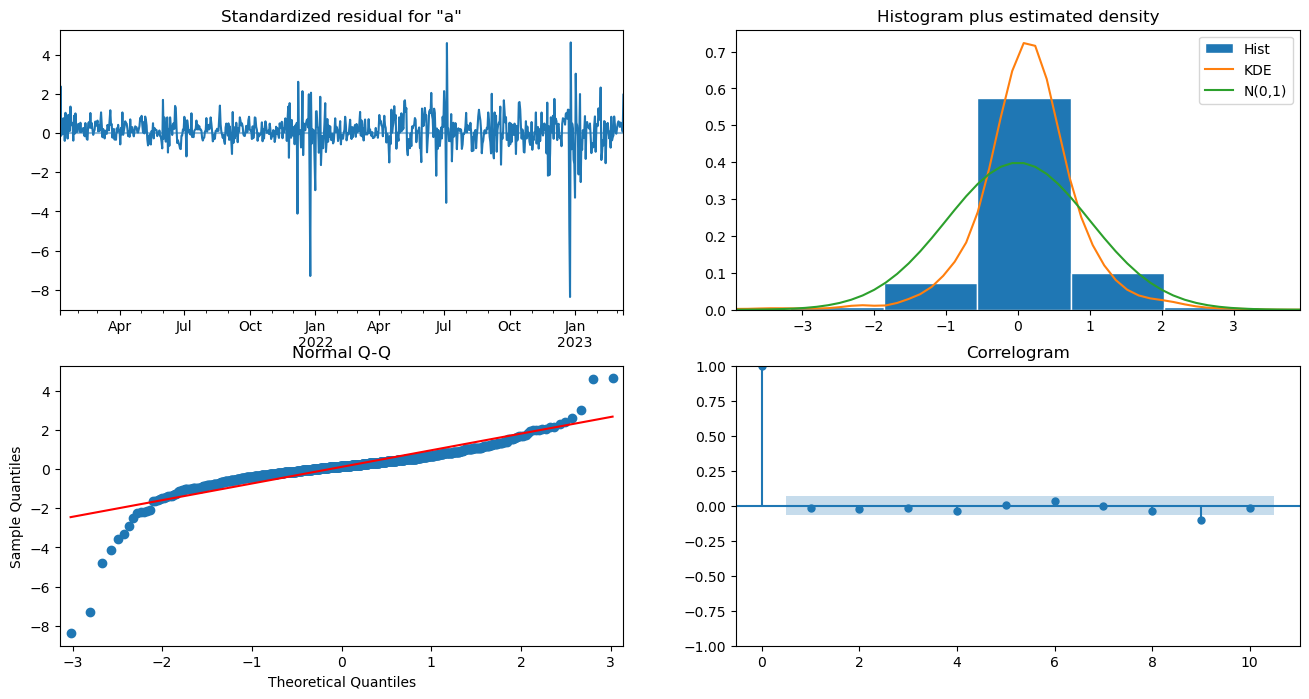

In [351]:
###NOTE THAT THERE ARE SOME DAYS WITH STRONG DEVIATIONS (DEC. 25, JAN. 1)
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [71]:
##WE NOW GENERATE THE FORECAST WITH THE ESTIMATED MODEL WITH THE TEST DATASET
pred = results.get_prediction(start=pd.to_datetime('2023-03-12'),end=pd.to_datetime('2023-03-30'), dynamic=False)
pred_test = pred.conf_int()
res = pred.predicted_mean
pred_test["result"] = pred.predicted_mean
pred_test["y"] = testdata
print("pred_test:\n", pred_test)

pred_test:
             lower amount  upper amount        result             y
2023-03-12  7.100951e+06  1.073576e+07  8.918357e+06  9.990582e+06
2023-03-13  6.246968e+06  9.980507e+06  8.113738e+06  7.865035e+06
2023-03-14  4.672313e+06  8.444561e+06  6.558437e+06  6.543219e+06
2023-03-15  4.081997e+06  7.899706e+06  5.990851e+06  6.847888e+06
2023-03-16  4.249192e+06  8.096039e+06  6.172616e+06  6.002096e+06
2023-03-17  7.632976e+06  1.149380e+07  9.563389e+06  1.023570e+07
2023-03-18  8.133404e+06  1.229423e+07  1.021382e+07  1.082097e+07
2023-03-19  6.396106e+06  1.065208e+07  8.524091e+06  9.213543e+06
2023-03-20  5.553807e+06  9.838331e+06  7.696069e+06  7.104772e+06
2023-03-21  4.045298e+06  8.342450e+06  6.193874e+06  5.707731e+06
2023-03-22  3.625249e+06  7.934425e+06  5.779837e+06  5.407997e+06
2023-03-23  3.896483e+06  8.213189e+06  6.054836e+06  5.449343e+06
2023-03-24  7.051404e+06  1.137190e+07  9.211654e+06  8.071606e+06
2023-03-25  7.698854e+06  1.209605e+07  9.897452e+

In [72]:
#FORECAST PERFORMANCE
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test["ae"] = abs(pred_test["y"]-pred_test["result"])
mae = pred_test["ae"].mean() 
print("mae:", mae)
mse = ((pred_test["y"]-pred_test["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test["pe"] = abs((pred_test["y"]-pred_test["result"]) / pred_test["y"])
mape = pred_test["pe"].mean() 
print("mape:", mape)


mae: 466039.3773934761
rmse: 564863.8102899819
mape: 0.06250582713403734


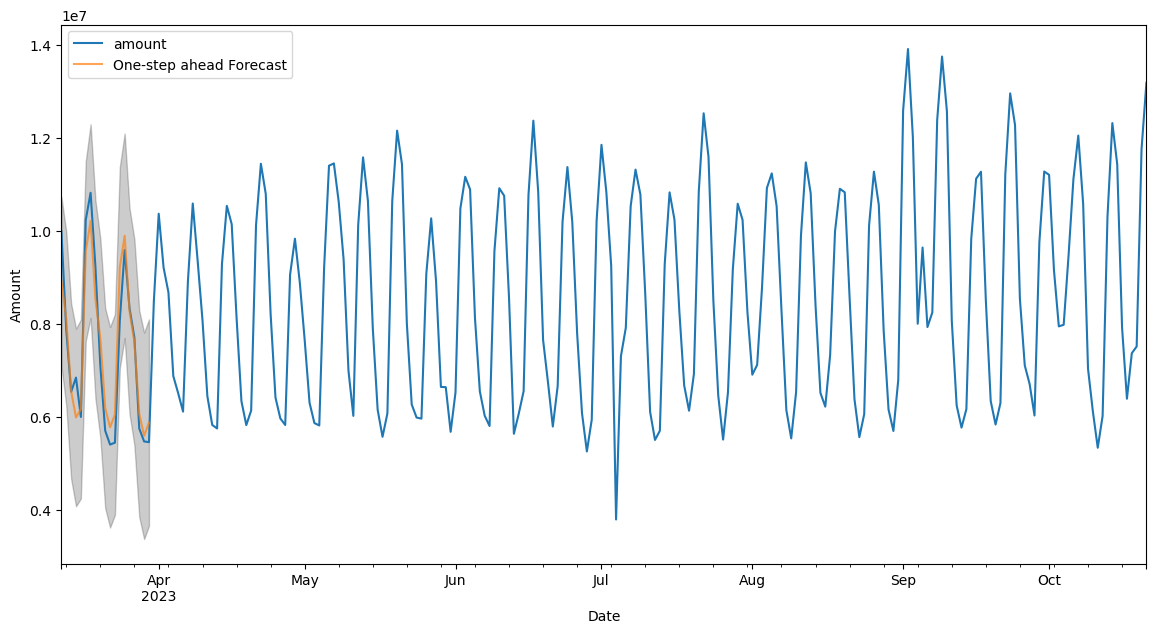

In [73]:
###GENERATE THE CONFIDENCE BANDS OF THE ESTIMATES (LOWER AND UPPER LIMIT) AND PLOT THE PREDICTED VALUE VS. THE ACTUAL VALUE

pred_ci = pred.conf_int()

#print("conf_int:", pred_ci)
#print("mean:", pred.predicted_mean)
p = pred.predicted_mean

ax = testdata.plot(label='observed')
#ax = traindata.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Amount')
plt.legend()

plt.show()

In [355]:
##WE NOW INCORPORATE THE EXCHANGE RATE LAGS AS PREDICTORS OF THE EXCHANGE RATE##

In [74]:
##TIME SERIES FORMAT
data2 = df_pilot
data2.dtypes #day object
data2['date'] = pd.DatetimeIndex(data2['date'])
df_pilot.dtypes   #Month datetime64[ns]

data2.index  #RangeIndex()
data2 = data2.set_index('date')

In [75]:
data2.head(1)

,payer,country,amount,symbol,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
date,,,,,,,,,,,,
2022-04-02,ELEKTRA (MEXICO),MEXICO,7469587.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
##WE ELIMINATE STRING VARIABLES##
data2=data2.loc[:,['amount', 'feed_price_retardo_1', 'feed_price_retardo_2', 'feed_price_retardo_3', 'feed_price_retardo_4', 'feed_price_retardo_5', 'feed_price_retardo_6', 'feed_price_retardo_7']]

In [77]:
data2 = data2.sort_values(by='date')

In [78]:
data2.head(3)

,amount,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
date,,,,,,,,
2020-12-31,2418346.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,717241.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,3360407.85,19.8822,NaN,NaN,NaN,NaN,NaN,NaN


In [361]:
##SARIMAX PARAMETER SEARCH##

In [82]:
traindata2 = data2[0:800] #data[0:800]
traindata2=traindata2.loc[:,['amount', 'feed_price_retardo_1', 'feed_price_retardo_2', 'feed_price_retardo_3', 'feed_price_retardo_4', 'feed_price_retardo_5', 'feed_price_retardo_6', 'feed_price_retardo_7']]
traindata2.index

DatetimeIndex(['2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09',
               ...
               '2023-03-01', '2023-03-02', '2023-03-03', '2023-03-04',
               '2023-03-05', '2023-03-06', '2023-03-07', '2023-03-08',
               '2023-03-09', '2023-03-10'],
              dtype='datetime64[ns]', name='date', length=800, freq=None)

In [83]:
testdata2 = data2[801:1025] #data[801:1025]
testdata2=testdata2.loc[:,['amount', 'feed_price_retardo_1','feed_price_retardo_2', 'feed_price_retardo_3', 'feed_price_retardo_4', 'feed_price_retardo_5', 'feed_price_retardo_6', 'feed_price_retardo_7']]
testdata2.index


DatetimeIndex(['2023-03-12', '2023-03-13', '2023-03-14', '2023-03-15',
               '2023-03-16', '2023-03-17', '2023-03-18', '2023-03-19',
               '2023-03-20', '2023-03-21',
               ...
               '2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15',
               '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19',
               '2023-10-20', '2023-10-21'],
              dtype='datetime64[ns]', name='date', length=224, freq=None)

In [84]:
traindata2.shape, testdata2.shape

((800, 8), (224, 8))

In [365]:
###NO OLVIDAR PROBAR DUMMIES 25/12 Y 01/01 EN AMBOS MODELOS!!!!!!!!!!!!!!!!!!!!

In [85]:
##WE TRY ANOTHER LIBRARY THAT DOES NOT HAVE PROBLEMS IN ADOPTING EXOGENOUS VARIABLES ##

###CLAVE: VER COMO ENTRENAR EL MODELO CON VARS EXOGENAS, NOTAR QUE ARRIBA SE LO ENTRENA CON AUTOARIMA (PROBLEMA, AUTOARIMA NO CAPTA POR ALGUNA RAZON LAS EXOGENAS)

import statsmodels.api as sm

###WE IMPUTE THE MISSING VALUES THAT GENERATE THE DIFFERENCES WITH SUBSEQUENT VALUES CLOSE IN TIME

traindata2=traindata2.fillna(method='bfill')
testdata2=testdata2.fillna(method='bfill')
traindata2=traindata2.fillna(method='ffill')
testdata2=testdata2.fillna(method='ffill')
exog=['feed_price_retardo_1','feed_price_retardo_2', 'feed_price_retardo_3', 'feed_price_retardo_4', 'feed_price_retardo_5', 'feed_price_retardo_6', 'feed_price_retardo_7']
mod = sm.tsa.SARIMAX(traindata2[['amount']], order=(1,0,0), seasonal_order =(2, 1, 2, 7), exog=traindata2[exog])
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                 amount   No. Observations:                  800
Model:             SARIMAX(1, 0, 0)x(2, 1, [1, 2], 7)   Log Likelihood              -11801.336
Date:                                Thu, 28 Dec 2023   AIC                          23628.671
Time:                                        13:20:06   BIC                          23689.457
Sample:                                    12-31-2020   HQIC                         23652.032
                                         - 03-10-2023                                         
Covariance Type:                                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
feed_price_retardo_1  1.184e+06   2.33e+05      5.077      0.0

In [87]:
testdata2.tail()

,amount,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
date,,,,,,,,
2023-10-17,6394084.62,17.9119,17.8337,18.2580,17.4065,17.4189,17.5294,17.6938
2023-10-18,7372639.68,17.9119,17.8337,18.2580,17.4065,17.4189,17.5294,17.6938
2023-10-19,7517141.00,17.9119,17.8337,18.2580,17.4065,17.4189,17.5294,17.6938
2023-10-20,11755749.86,18.3207,17.9119,17.8337,18.2580,17.4065,17.4189,17.5294
2023-10-21,13185622.15,18.3207,17.9119,17.8337,18.2580,17.4065,17.4189,17.5294


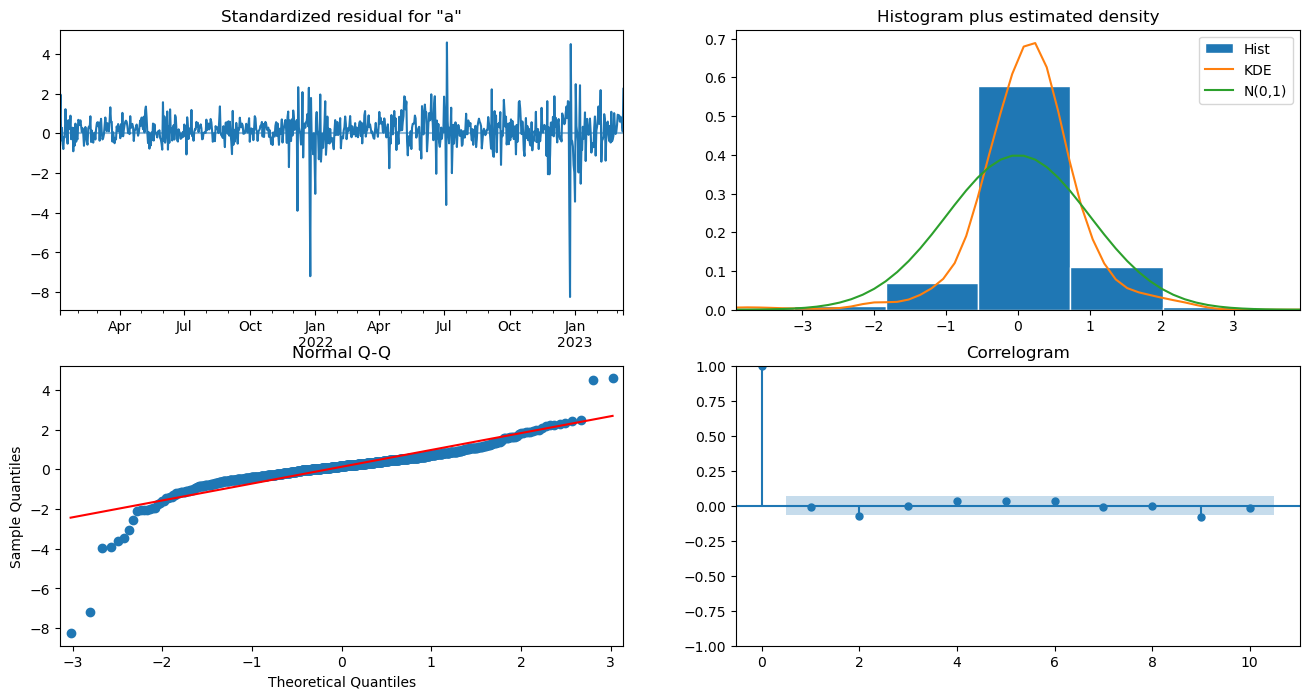

In [88]:
res.plot_diagnostics(figsize=(16, 8))
plt.show()

In [89]:
testdata2=testdata2[0:20]
pred2 = res.get_prediction(start=pd.to_datetime('2023-03-12'),end=pd.to_datetime('2023-03-30'), dynamic=False, exog=testdata2[exog])
pred_test2 = pred2.conf_int()
res2 = pred2.predicted_mean
pred_test2["result"] = pred2.predicted_mean
pred_test2["y"] = testdata2['amount']
print("pred_test2:\n", pred_test2)

pred_test2:
             lower amount  upper amount        result             y
2023-03-12  7.439970e+06  1.090782e+07  9.173896e+06  9.990582e+06
2023-03-13  7.195310e+06  1.073280e+07  8.964056e+06  7.865035e+06
2023-03-14  5.467415e+06  9.020231e+06  7.243823e+06  6.543219e+06
2023-03-15  4.724219e+06  8.280439e+06  6.502329e+06  6.847888e+06
2023-03-16  4.967611e+06  8.524588e+06  6.746100e+06  6.002096e+06
2023-03-17  8.305662e+06  1.186281e+07  1.008423e+07  1.023570e+07
2023-03-18  8.553747e+06  1.237322e+07  1.046348e+07  1.082097e+07
2023-03-19  6.442609e+06  1.031809e+07  8.380347e+06  9.213543e+06
2023-03-20  5.776387e+06  9.664228e+06  7.720308e+06  7.104772e+06
2023-03-21  3.804777e+06  7.695366e+06  5.750071e+06  5.707731e+06
2023-03-22  3.463676e+06  7.354877e+06  5.409276e+06  5.407997e+06
2023-03-23  3.770991e+06  7.662328e+06  5.716659e+06  5.449343e+06
2023-03-24  6.991820e+06  1.088319e+07  8.937503e+06  8.071606e+06
2023-03-25  7.645232e+06  1.160922e+07  9.627228e

In [90]:
#FORECAST PERFORMANCE
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test2["ae"] = abs(pred_test2["y"]-pred_test2["result"])
mae = pred_test2["ae"].mean() 
print("mae:", mae)
mse = ((pred_test2["y"]-pred_test2["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test2["pe"] = abs((pred_test2["y"]-pred_test2["result"]) / pred_test2["y"])
mape = pred_test2["pe"].mean() 
print("mape:", mape)

mae: 446324.29197574506
rmse: 550671.5024109794
mape: 0.059640289392460064


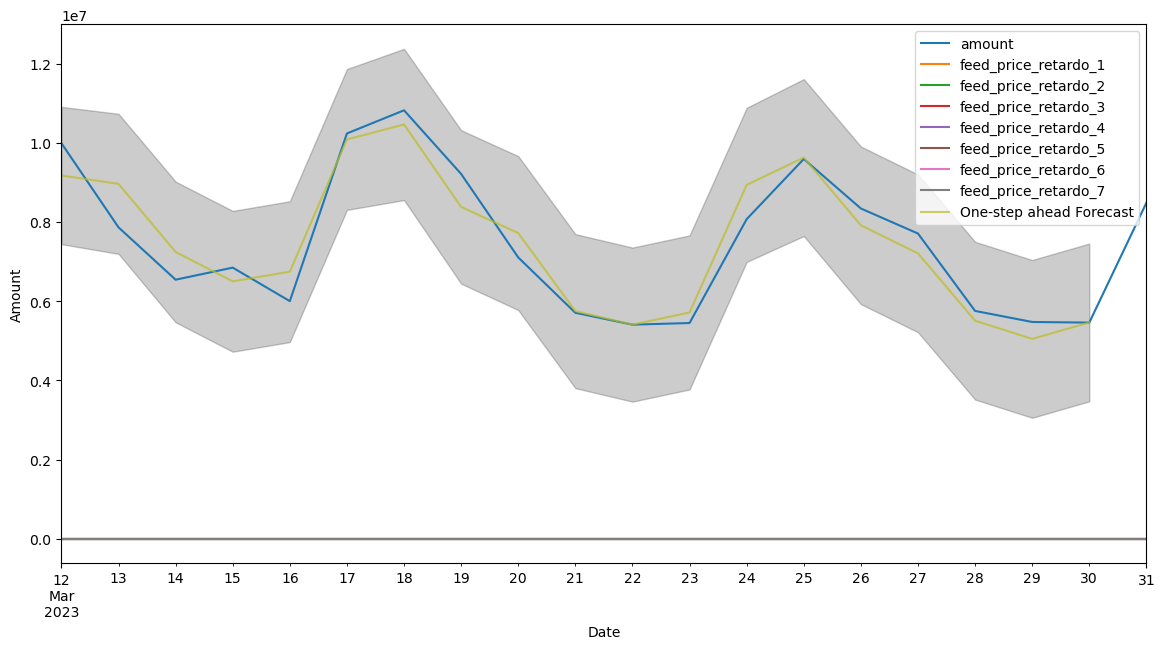

In [91]:

pred_ci2 = pred2.conf_int()

#print("conf_int:", pred_ci)
#print("mean:", pred.predicted_mean)
p = pred2.predicted_mean

ax = testdata2.plot(label='observed')
#ax = traindata.plot(label='observed')
pred2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Amount')
plt.legend()

plt.show()

In [ ]:
##SAME APPROACH BUT WORKING WITH DAILY EXCHANGE RATE DIFFERENCES

In [92]:
data3=data2.copy()

In [93]:
data3=data3.fillna(method='bfill')
data3=data3.fillna(method='ffill')

In [94]:
data3['var_rate_lag1']=data3.feed_price_retardo_1-data3.feed_price_retardo_2
data3['var_rate_lag2']=data3.feed_price_retardo_2-data3.feed_price_retardo_3
data3['var_rate_lag3']=data3.feed_price_retardo_3-data3.feed_price_retardo_4
data3['var_rate_lag4']=data3.feed_price_retardo_4-data3.feed_price_retardo_5
data3['var_rate_lag5']=data3.feed_price_retardo_5-data3.feed_price_retardo_6
data3['var_rate_lag6']=data3.feed_price_retardo_6-data3.feed_price_retardo_7
data3.tail(2)

,amount,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6
date,,,,,,,,,,,,,,
2023-10-20,11755749.86,18.3207,17.9119,17.8337,18.258,17.4065,17.4189,17.5294,0.4088,0.0782,-0.4243,0.8515,-0.0124,-0.1105
2023-10-21,13185622.15,18.3207,17.9119,17.8337,18.258,17.4065,17.4189,17.5294,0.4088,0.0782,-0.4243,0.8515,-0.0124,-0.1105


In [95]:
##WE ELIMINATE SOME VARIABLES##
data3=data3.loc[:,['amount', 'var_rate_lag1', 'var_rate_lag2', 'var_rate_lag3', 'var_rate_lag4', 'var_rate_lag5', 'var_rate_lag6']]
data3.tail()

,amount,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6
date,,,,,,,
2023-10-17,6394084.62,0.0782,-0.4243,0.8515,-0.0124,-0.1105,-0.1644
2023-10-18,7372639.68,0.0782,-0.4243,0.8515,-0.0124,-0.1105,-0.1644
2023-10-19,7517141.00,0.0782,-0.4243,0.8515,-0.0124,-0.1105,-0.1644
2023-10-20,11755749.86,0.4088,0.0782,-0.4243,0.8515,-0.0124,-0.1105
2023-10-21,13185622.15,0.4088,0.0782,-0.4243,0.8515,-0.0124,-0.1105


In [ ]:
##SARIMAX PARAMETER SEARCH##

In [96]:
traindata3 = data3[0:800] #data[0:800]
traindata3.index

DatetimeIndex(['2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09',
               ...
               '2023-03-01', '2023-03-02', '2023-03-03', '2023-03-04',
               '2023-03-05', '2023-03-06', '2023-03-07', '2023-03-08',
               '2023-03-09', '2023-03-10'],
              dtype='datetime64[ns]', name='date', length=800, freq=None)

In [97]:
testdata3 = data3[801:1025] #data[801:1025]
testdata3.index

DatetimeIndex(['2023-03-12', '2023-03-13', '2023-03-14', '2023-03-15',
               '2023-03-16', '2023-03-17', '2023-03-18', '2023-03-19',
               '2023-03-20', '2023-03-21',
               ...
               '2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15',
               '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19',
               '2023-10-20', '2023-10-21'],
              dtype='datetime64[ns]', name='date', length=224, freq=None)

In [98]:
traindata3.shape, testdata3.shape

((800, 7), (224, 7))

In [99]:
##WE TRY ANOTHER LIBRARY THAT DOES NOT HAVE PROBLEMS IN ADOPTING EXOGENOUS VARIABLES ##

###CLAVE: VER COMO ENTRENAR EL MODELO CON VARS EXOGENAS, NOTAR QUE ARRIBA SE LO ENTRENA CON AUTOARIMA (PROBLEMA, AUTOARIMA NO CAPTA POR ALGUNA RAZON LAS EXOGENAS)

import statsmodels.api as sm

###WE IMPUTE THE MISSING VALUES THAT GENERATE THE DIFFERENCES WITH SUBSEQUENT VALUES CLOSE IN TIME

exog3=['var_rate_lag1', 'var_rate_lag2', 'var_rate_lag3', 'var_rate_lag4', 'var_rate_lag5', 'var_rate_lag6']
mod2 = sm.tsa.SARIMAX(traindata3[['amount']], order=(1,0,0), seasonal_order =(2, 1, 2, 7), exog=traindata3[exog3])
res2 = mod2.fit(maxiter=1000, disp=False)
print(res2.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                 amount   No. Observations:                  800
Model:             SARIMAX(1, 0, 0)x(2, 1, [1, 2], 7)   Log Likelihood              -11807.010
Date:                                Thu, 28 Dec 2023   AIC                          23638.021
Time:                                        13:21:19   BIC                          23694.131
Sample:                                    12-31-2020   HQIC                         23659.585
                                         - 03-10-2023                                         
Covariance Type:                                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
var_rate_lag1  1.123e+06   2.75e+05      4.088      0.000    5.85e+05    1.6

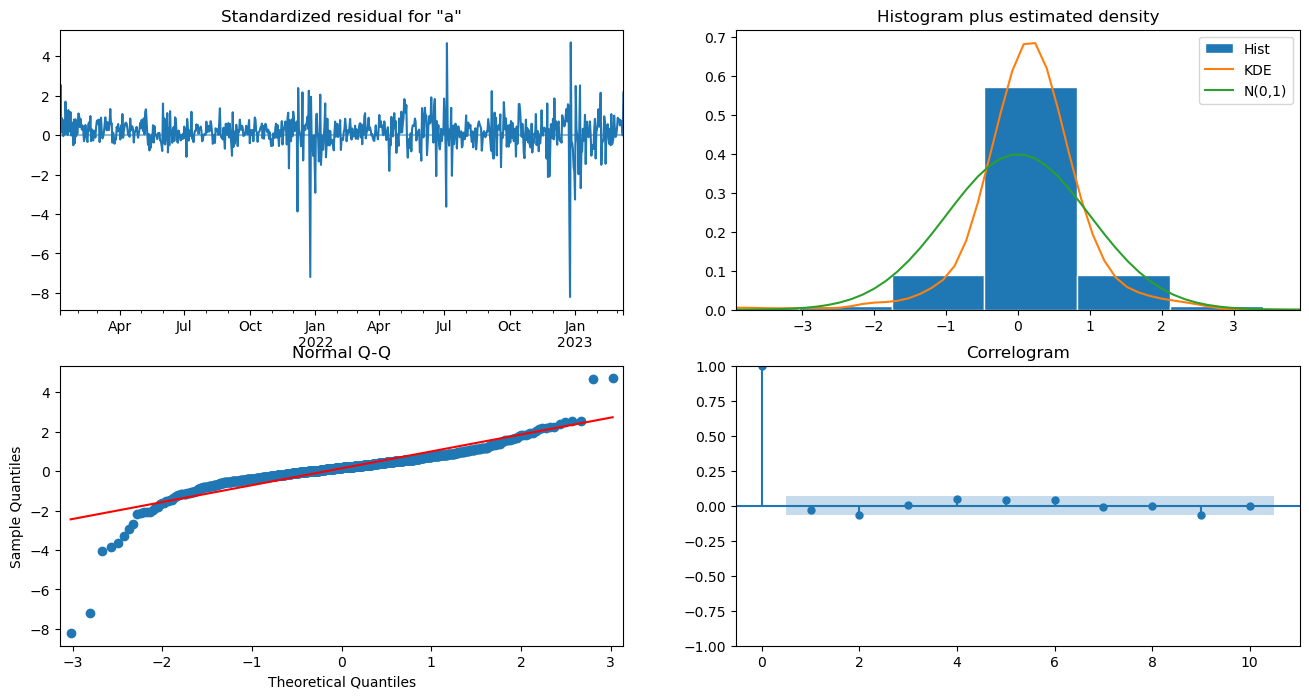

In [100]:
res2.plot_diagnostics(figsize=(16, 8))
plt.show()

In [101]:
testdata3=testdata3[0:20]
pred3 = res2.get_prediction(start=pd.to_datetime('2023-03-12'),end=pd.to_datetime('2023-03-30'), dynamic=False, exog=testdata3[exog3])
pred_test3 = pred3.conf_int()
res2 = pred3.predicted_mean
pred_test3["result"] = pred3.predicted_mean
pred_test3["y"] = testdata3['amount']
print("pred_test2:\n", pred_test3)

pred_test2:
             lower amount  upper amount        result             y
2023-03-12  7.538256e+06  1.103643e+07  9.287343e+06  9.990582e+06
2023-03-13  7.248733e+06  1.083105e+07  9.039890e+06  7.865035e+06
2023-03-14  5.506254e+06  9.108991e+06  7.307623e+06  6.543219e+06
2023-03-15  4.741719e+06  8.349469e+06  6.545594e+06  6.847888e+06
2023-03-16  4.967354e+06  8.576338e+06  6.771846e+06  6.002096e+06
2023-03-17  8.328936e+06  1.193822e+07  1.013358e+07  1.023570e+07
2023-03-18  8.598679e+06  1.248782e+07  1.054325e+07  1.082097e+07
2023-03-19  6.445904e+06  1.040094e+07  8.423421e+06  9.213543e+06
2023-03-20  5.781567e+06  9.752665e+06  7.767116e+06  7.104772e+06
2023-03-21  3.773399e+06  7.748443e+06  5.760921e+06  5.707731e+06
2023-03-22  3.424179e+06  7.400195e+06  5.412187e+06  5.407997e+06
2023-03-23  3.721995e+06  7.698250e+06  5.710122e+06  5.449343e+06
2023-03-24  6.956834e+06  1.093315e+07  8.944991e+06  8.071606e+06
2023-03-25  7.624607e+06  1.167993e+07  9.652268e

In [102]:
#FORECAST PERFORMANCE
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test3["ae"] = abs(pred_test3["y"]-pred_test3["result"])
mae = pred_test3["ae"].mean() 
print("mae:", mae)
mse = ((pred_test3["y"]-pred_test3["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test3["pe"] = abs((pred_test3["y"]-pred_test3["result"]) / pred_test3["y"])
mape = pred_test3["pe"].mean() 
print("mape:", mape)

mae: 436630.60318145645
rmse: 547513.6948245248
mape: 0.05886123190237519


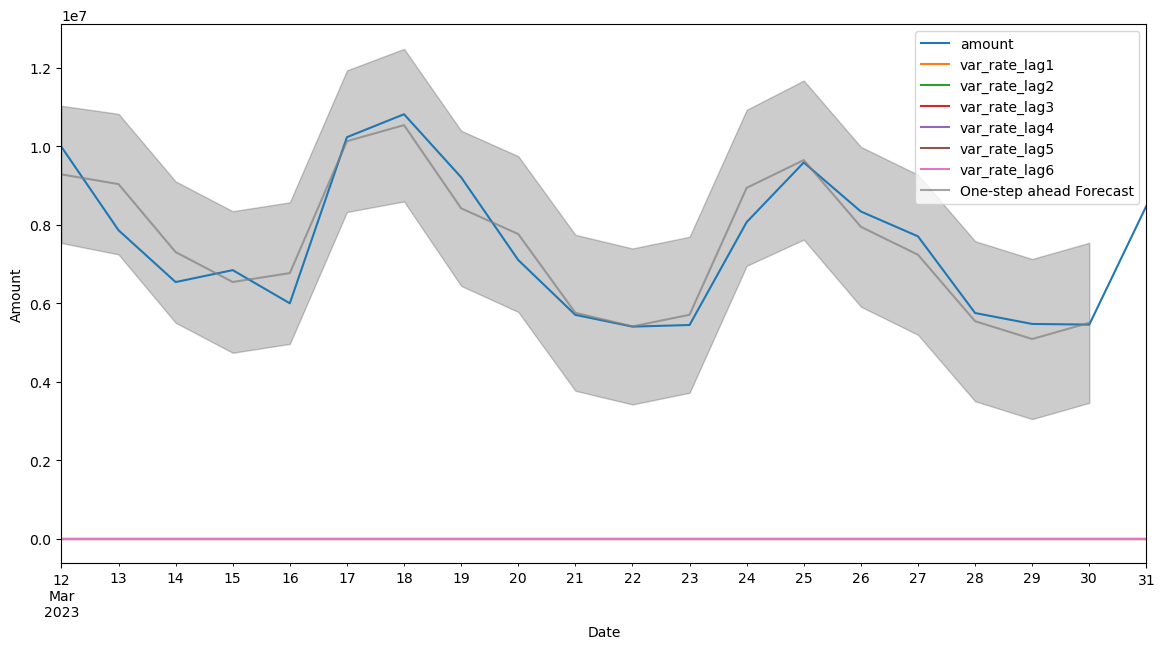

In [103]:
pred_ci3 = pred3.conf_int()

#print("conf_int:", pred_ci)
#print("mean:", pred.predicted_mean)
p = pred3.predicted_mean

ax = testdata3.plot(label='observed')
#ax = traindata.plot(label='observed')
pred3.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci3.index,
                pred_ci3.iloc[:, 0],
                pred_ci3.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Amount')
plt.legend()

plt.show()

In [ ]:
##DESARROLLAR UNA RUTINA QUE LO ENTRENE EN FORMA AUTOMÁTICA O AL MENOS SENCILLA PARA BUSCAR EL MEJOR MODELO##
##UNA VEZ HECHO ESTO, RECORDAR PASAR ESTE DESARROLLO A SARIMAX Y AHI CONTINUAR CON LA ESTIMACIÓN PARA TODOS LOS PAYERS DEL UNIVERSO DE DATOS (131 APROX)
##PROBAR TAMBIEN ALEJAR EN EL TIEMPO TRAIN Y TEST EN TODAS LAS VERSIONES Y CAMBIAR LOS PERIODOS DE ENTRENAMIENTO Y TEST PARA VER SENSIBILIDAD##


In [ ]:
###AJUSTAR ARIMA SIMPLE PARA TODO MÉXICO DE MANERA DE PODER COMPARAR  CONTRA LA TABLA DE PRONOSTICOS ENVIADOS POR VIAMERICAS##